In [15]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch
from torchvision import transforms
from networks.mlp_models import MLP3D
from data.neural_field_datasets_shapenet import AllWeights3D, ModelTransform3D, ShapeNetDataset, FlattenTransform3D, ZScore3D, get_neuron_mean_n_std, get_total_mean_n_std


shapeNetData = ShapeNetDataset("./datasets/plane_mlp_weights", transform=AllWeights3D())
means, stds = get_neuron_mean_n_std(shapeNetData)
shapeNetData_normalized = ShapeNetDataset("./datasets/plane_mlp_weights", transform=[AllWeights3D(), ZScore3D(means, 1)])

all_weights = torch.stack([sample[0] for sample in shapeNetData])
all_weights_normalized = torch.stack([sample[0] for sample in shapeNetData_normalized])

In [8]:
dataset = ShapeNetDataset("./datasets/plane_mlp_weights", transform=AllWeights3D())
means_neurons, _ = get_neuron_mean_n_std(dataset)
normalize_1 = ZScore3D(means_neurons, 1)

shapeNetData_normalized = ShapeNetDataset("./datasets/plane_mlp_weights", transform=[AllWeights3D(), normalize_1])
mean_total, std_total = get_total_mean_n_std(shapeNetData_normalized)
normalize_1 = ZScore3D(means_neurons, 1)
normalize_2 = ZScore3D(mean_total, std_total)
shapeNetData_normalized = ShapeNetDataset("./datasets/plane_mlp_weights", transform=[AllWeights3D(), normalize_1, normalize_2])

In [19]:
shapeNetData_flattened = ShapeNetDataset("./datasets/plane_mlp_weights", transform=[FlattenTransform3D()])

In [22]:
all_weights_flattened = torch.stack([sample[0] for sample in shapeNetData_flattened])

In [4]:
from vector_quantize_pytorch import ResidualVQ

rq_path = "./models/rq_search_results/rq_model_dim_128_vocab_128_batch_size_2048_threshold_ema_dead_code_0_kmean_iters_0_num_quantizers_16_use_init_False.pth"
rqt_dict = torch.load(rq_path)
rqt = ResidualVQ(**rqt_dict["rq_config"])
rqt.load_state_dict(rqt_dict["state_dict"])

<All keys matched successfully>

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_normalized.view(-1, 128)

pos_enc = torch.Tensor([i for _ in range(3883) for i in range(287)]).unsqueeze(-1)
concatenated_data = torch.cat((data, pos_enc), dim=1)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.n_emb_input = 128
        self.n_emb_latent = 128
        
        self.emb_input = nn.Embedding(287, self.n_emb_input)
        self.emb_latent = nn.Embedding(287, self.n_emb_latent)
        
        self.encoder = nn.Sequential(
            nn.Linear(128 + self.n_emb_input, 112 + int(self.n_emb_input/2)),
            nn.GELU(),
            nn.Linear(112 + int(self.n_emb_input/2), 96 + int(self.n_emb_input/4)),
            nn.GELU(),
            nn.Linear(96 + int(self.n_emb_input/4), 80),
            nn.GELU(),
            nn.Linear(80, 72),
            nn.GELU(),
            nn.Linear(72, 64),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64 + self.n_emb_latent, 64 + self.n_emb_latent),
            nn.GELU(),
            nn.Linear(64 + self.n_emb_latent, 64 + self.n_emb_latent),
            nn.GELU(),
            nn.Linear(64 + self.n_emb_latent, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):
        pos = x[:, -1].int()
        embedding_input = self.emb_input(pos)
        x = torch.cat((x[:, :-1], embedding_input), dim=1)
        latent = self.encoder(x)
        embedding_latent = self.emb_latent(pos)

        reconstructed = self.decoder(torch.cat((latent, embedding_latent), dim=1))
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 100
batch_size = 128
data_loader = torch.utils.data.DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

exp_avg_loss = None

for epoch in range(num_epochs):
    bar = tqdm(data_loader)
    for batch in bar:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch[:, :128])
        loss.backward()
        optimizer.step()
        if exp_avg_loss == None:
            exp_avg_loss = loss
        exp_avg_loss = 0.95*exp_avg_loss + 0.05*loss
        bar.set_description("Loss %f" % exp_avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# # Plot each class with its respective color
for class_idx in range(27):
    class_data = latent_space[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])


ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


Loss 0.186041:  25%|██▍       | 2136/8707 [00:58<03:00, 36.37it/s] 


KeyboardInterrupt: 

In [15]:
idx = 0
sample = shapeNetData_normalized[idx][0]
quantized, indices, loss = rqt(sample)

quantized_unnormalized, _ = normalize_2.reverse(quantized, 0)
sample_unnormalized, _ = normalize_2.reverse(sample, 0)

error_unnormalized = quantized_unnormalized - sample_unnormalized
error_normalized = quantized - sample


print(error_normalized.abs().mean())
print(error_unnormalized.abs().mean())

tensor(0.2624)
tensor(0.1452)


In [16]:
shapeNetData_normalized[idx][0]

tensor([[-2.0924e+00, -2.2313e-01,  2.3014e-01,  ...,  3.0550e-03,
         -2.8013e-01,  4.1717e-01],
        [-4.1402e+00,  1.9662e+00, -2.1424e-01,  ...,  6.0184e-04,
          1.4366e-01, -3.7160e-01],
        [-3.5188e-01,  5.9574e-01,  7.7308e-02,  ..., -1.7949e-03,
          1.1308e-01, -1.5163e+00],
        ...,
        [ 1.1646e-02,  2.2889e-01,  3.9738e-02,  ...,  8.8077e-03,
         -1.7952e-01,  2.5037e-01],
        [-2.3902e-01, -4.9768e-01,  7.3541e-03,  ..., -2.1367e-01,
         -7.2591e-01,  5.4723e-02],
        [-1.1129e+00,  8.4412e-02, -7.9058e-01,  ...,  1.1503e-01,
          2.0368e-01, -1.1486e+00]])

tensor(0.2569)

In [50]:
error

tensor([[-3.0526, -1.1850,  0.2934,  ...,  0.0496, -0.2738,  0.3370],
        [-4.4214, -2.6809, -0.0831,  ...,  0.0794, -0.5277,  0.4684],
        [ 0.0644,  0.3271,  0.0820,  ...,  0.0805, -0.1346, -0.5545],
        ...,
        [-0.0505, -0.4832, -0.0917,  ...,  0.0497, -0.0571,  0.1355],
        [ 0.2078, -0.8547,  0.2814,  ...,  1.2197,  1.0312,  1.3977],
        [-1.0739,  1.5398, -0.5407,  ...,  0.1523, -0.1531, -0.2669]])

Shape of data is  torch.Size([287, 128])
Outlier neurons are  [[1, 10, 16, 22, 149], [1, 4, 10, 16, 22], [1, 10, 16, 22, 149], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 10, 16, 127, 139], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [1, 10, 16, 22, 149], [1, 10, 16, 22, 70], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22], [55, 103, 117, 132, 149], [1, 4, 10, 16, 22], [1, 10, 16, 22, 53], [1, 10, 16, 22, 75], [1, 4, 10, 16, 22], [1, 4, 10, 16, 22]]


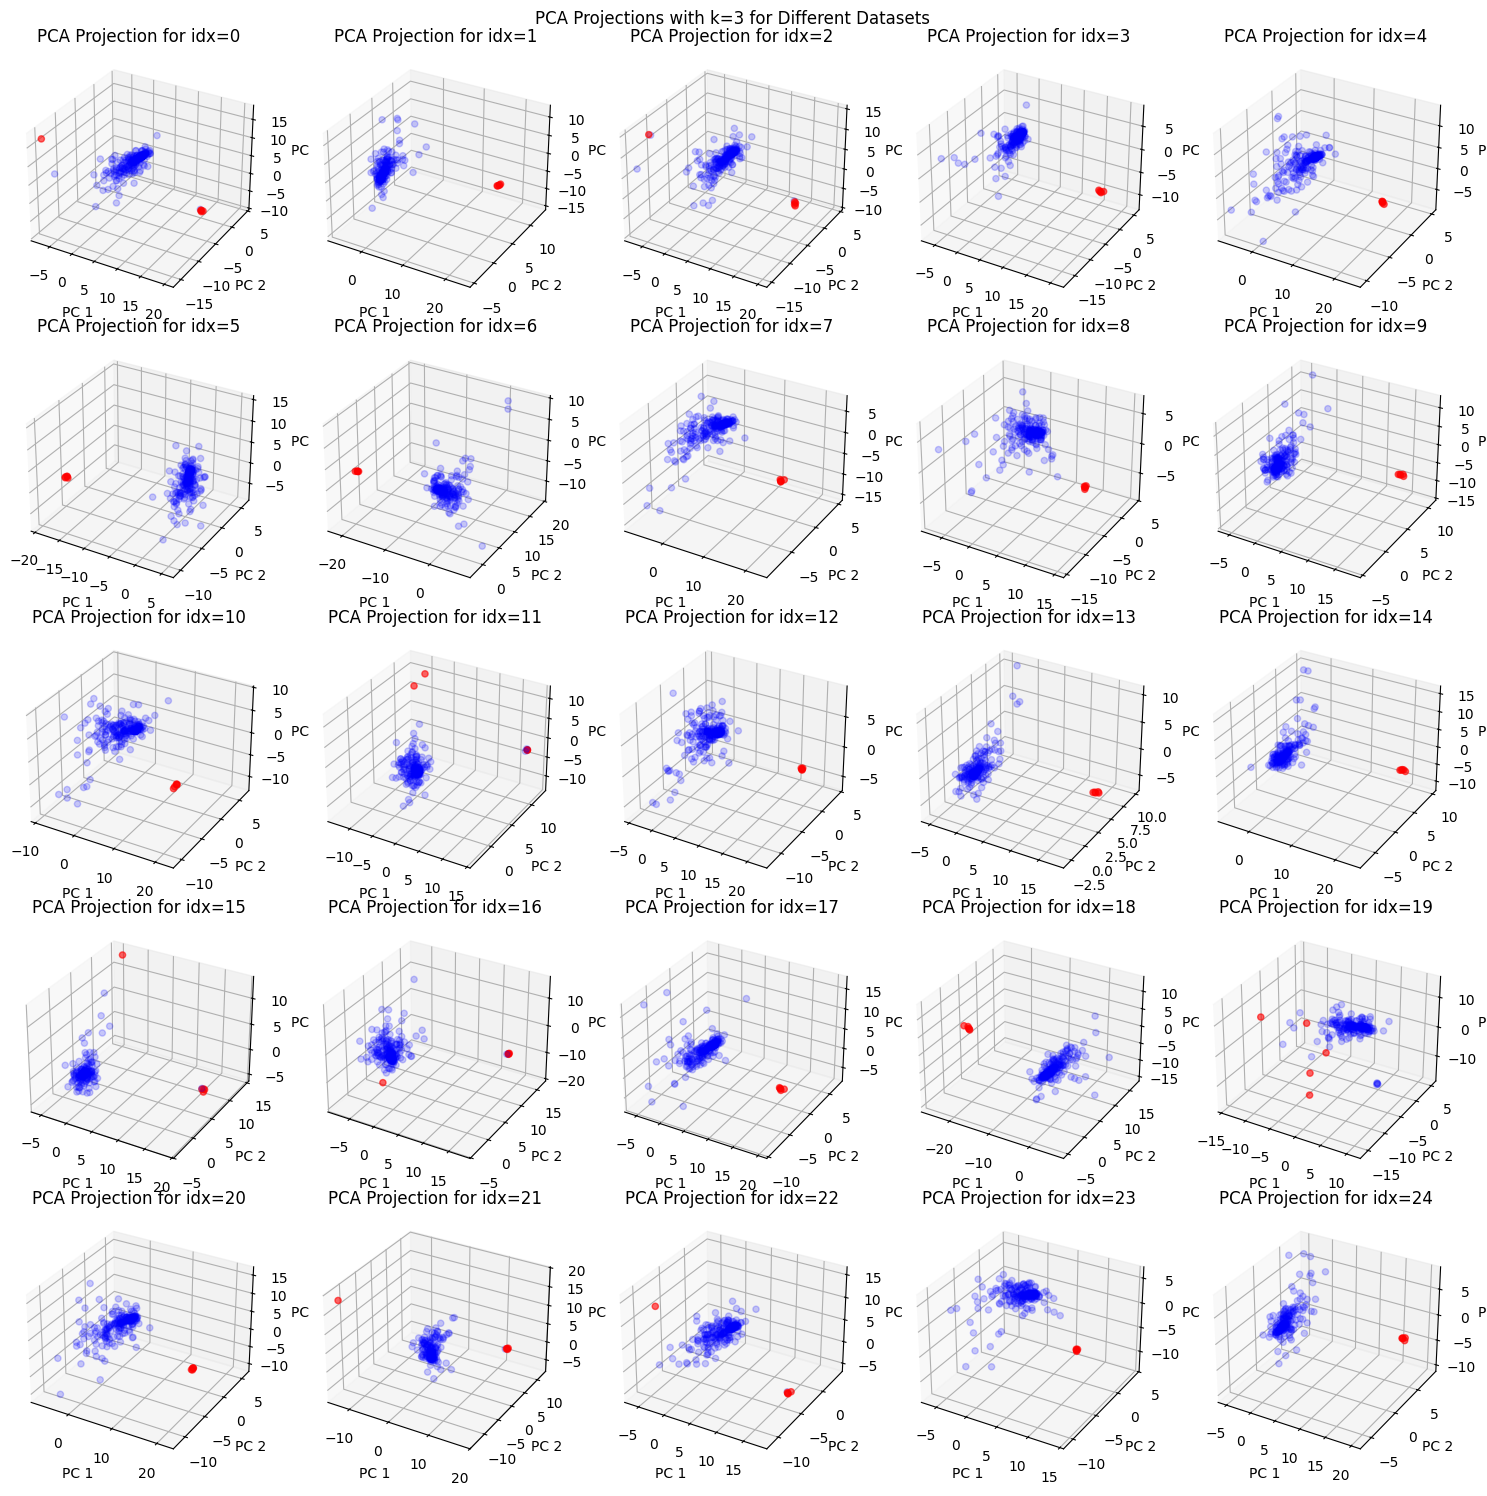

In [10]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot weights of different datasamples

# List of indices for different datasets
idxs = range(25)
#idxs = range(25, 50)

# Define the maximum norm
max_norm_count = 5

# Create a figure with 9 subplots
fig = plt.figure(figsize=(15, 15))

# Array to store indices of high norm points for each dataset
high_norm_indices = []

# Loop over each index and generate the PCA plot
for i, idx in enumerate(idxs):
    # Reshape the data
    data = shapeNetData[idx][0]

    # Center the data
    mean = torch.mean(data, dim=0)
    data_centered = data - mean

    # Compute the covariance matrix
    cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

    # Sort eigenvectors by decreasing eigenvalues
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select top 3 eigenvectors
    k = 3
    principal_components = eigenvectors[:, :k]

    # Project the data onto the top 3 principal components
    data_projected = torch.mm(data_centered, principal_components)

    # Compute norms
    norms = torch.linalg.norm(data_projected, dim=1)

    # Identify points with norm greater than max_norm
    high_norm_points = norms >= norms.sort().values[-max_norm_count]

    # Save indices of high norm points
    high_norm_indices.append(torch.nonzero(high_norm_points).squeeze().tolist())

    # Add subplot for the current index
    ax = fig.add_subplot(5, 5, i + 1, projection='3d')
    
    # Plot points with norm <= max_norm in blue
    ax.scatter(data_projected[~high_norm_points, 0], data_projected[~high_norm_points, 1], data_projected[~high_norm_points, 2], c='blue', alpha=0.2)
    
    # Plot points with norm > max_norm in red
    ax.scatter(data_projected[high_norm_points, 0], data_projected[high_norm_points, 1], data_projected[high_norm_points, 2], c='red', alpha=0.6)
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(f'PCA Projection for idx={idx}')
    
print("Shape of data is ", data.shape)

print("Outlier neurons are ", high_norm_indices)

plt.suptitle('PCA Projections with k=3 for Different Datasets')
plt.tight_layout()
plt.show()




Shape of data is  torch.Size([4045, 128])


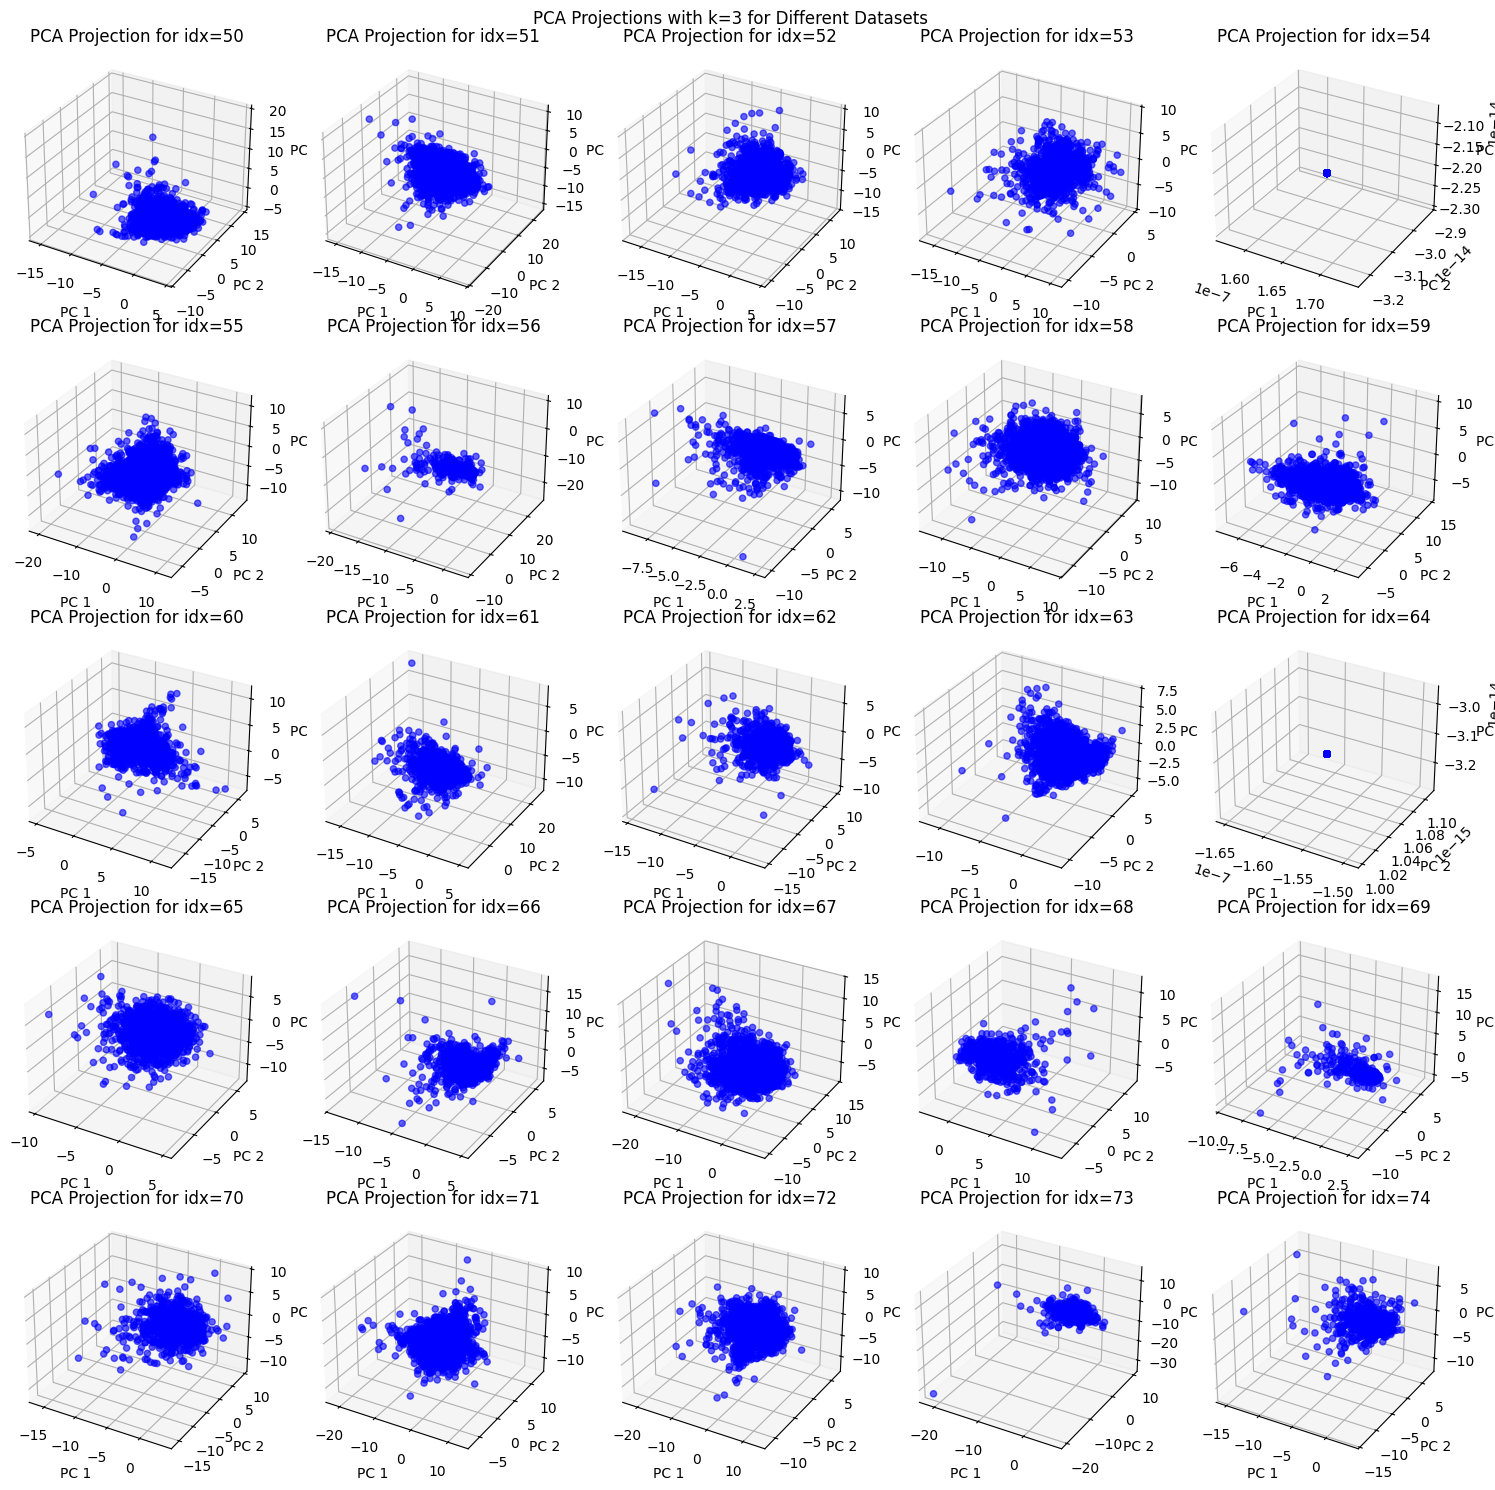

In [98]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# List of indices for different datasets
idxs = range(50, 75)

# Plot weights of different neurons

# Define the maximum norm
max_norm_count = 5

# Create a figure with 9 subplots
fig = plt.figure(figsize=(15, 15))

# Array to store indices of high norm points for each dataset
high_norm_indices = []

# Loop over each index and generate the PCA plot
for i, idx in enumerate(idxs):
    # Reshape the data
    data = all_weights[:, idx, :].view(-1, 128)

    # Center the data
    mean = torch.mean(data, dim=0)
    data_centered = data - mean

    # Compute the covariance matrix
    cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

    # Sort eigenvectors by decreasing eigenvalues
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select top 3 eigenvectors
    k = 3
    principal_components = eigenvectors[:, :k]

    # Project the data onto the top 3 principal components
    data_projected = torch.mm(data_centered, principal_components)

    # Compute norms
    norms = torch.linalg.norm(data_projected, dim=1)

    # Add subplot for the current index
    ax = fig.add_subplot(5, 5, i + 1, projection='3d')
    
    # Plot points with norm <= max_norm in blue    
    # Plot points with norm > max_norm in red
    ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2], c='blue', alpha=0.6)
    
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(f'PCA Projection for idx={idx}')
    
    
print("Shape of data is [idx nef, weight tensor]", data.shape)

plt.suptitle('PCA Projections with k=3 for Different Datasets')
plt.tight_layout()
plt.show()





In [68]:
all_weights.shape

torch.Size([4045, 287, 128])

In [ ]:
all_weights

IndexError: The shape of the mask [1160915] at index 0 does not match the shape of the indexed tensor [8391163, 3] at index 0

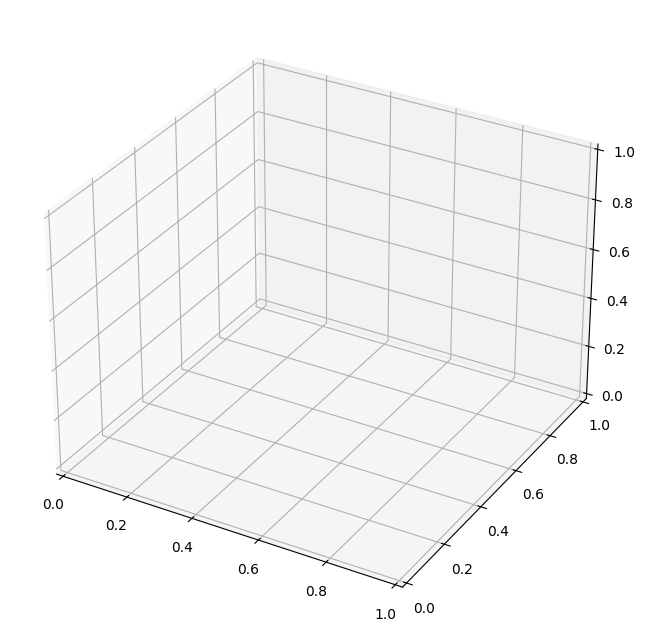

In [23]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights.view(-1, 128)

# Center the data
mean = torch.mean(data, dim=0)
data_centered = data - mean

# Compute the covariance matrix
cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

# Sort eigenvectors by decreasing eigenvalues
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, sorted_indices]

# Select top 3 eigenvectors
k = 3
principal_components = eigenvectors[:, :k]

# Project the data onto the top 3 principal components
data_projected = torch.mm(data_centered, principal_components)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


# weights layer 0
for class_idx in range(27):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="red")

# weights layer 1
for class_idx in range(27, 27 + 128):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="blue")
    
# weights layer 2
for class_idx in range(27 + 128, 27 + 2*128):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="black")
    
# weights layer 3
for class_idx in range(27 + 2*128, 27 + 2*128 + 1):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="green")



ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('PCA Projection with k=3')
plt.legend()
plt.show()



In [27]:
shapeNetData_flattened[0][0].view(-1, 17).shape

torch.Size([2161, 17])

In [28]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_flattened.view(-1, 17)

# Center the data
mean = torch.mean(data, dim=0)
data_centered = data - mean

# Compute the covariance matrix
cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

# Sort eigenvectors by decreasing eigenvalues
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, sorted_indices]

# Select top 3 eigenvectors
k = 3
principal_components = eigenvectors[:, :k]

# Project the data onto the top 3 principal components
data_projected = torch.mm(data_centered, principal_components)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data_projected[:, 0], data_projected[:, 1], data_projected[:, 2], alpha=0.6, c="red")


ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('PCA Projection with k=3')
plt.legend()
plt.show()



RuntimeError: shape '[-1, 34]' is invalid for input of size 142649771

In [141]:
from tqdm import tqdm
all_nef_weights = all_weights_normalized.view(3883, -1)

all_errors = torch.stack([torch.linalg.norm(all_nef_weights - nef_weight, dim=1).mean() for nef_weight in tqdm(all_nef_weights)])

100%|██████████| 3883/3883 [02:49<00:00, 22.89it/s]


(array([ 4.,  3.,  4.,  3.,  5.,  4., 10., 11.,  5., 15., 17., 14., 18.,
        22., 21., 22., 20., 22., 43., 35., 35., 27., 43., 40., 61., 63.,
        60., 66., 76., 59., 71., 78., 71., 78., 72., 81., 65., 91., 83.,
        95., 75., 83., 73., 87., 88., 73., 86., 70., 61., 71., 70., 71.,
        66., 56., 55., 50., 52., 52., 60., 59., 40., 35., 46., 35., 39.,
        41., 36., 50., 32., 31., 38., 27., 17., 23., 25., 25., 23., 21.,
        26., 24., 24., 32., 11., 25., 17., 17., 15., 13., 10., 12., 16.,
        20., 11.,  7.,  6., 10., 11.,  6.,  7.,  8.]),
 array([123.46669006, 124.02029419, 124.57389069, 125.12749481,
        125.68109894, 126.23469543, 126.78829956, 127.34190369,
        127.89550018, 128.44909668, 129.00270081, 129.55630493,
        130.10990906, 130.66351318, 131.21711731, 131.77070618,
        132.3243103 , 132.87791443, 133.43151855, 133.98512268,
        134.53872681, 135.09231567, 135.6459198 , 136.19952393,
        136.75312805, 137.30673218, 137.8603363 , 

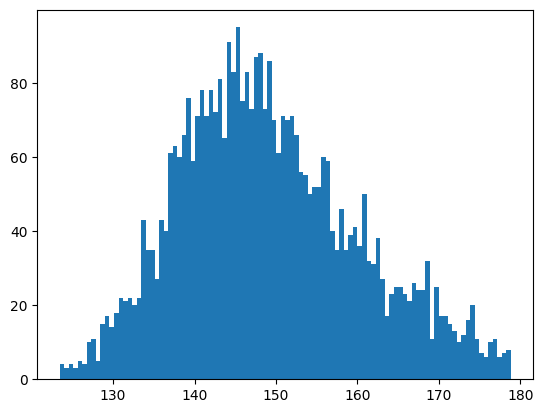

In [142]:
import matplotlib.pyplot as plt

plt.hist(all_errors, bins = 100)

In [120]:
(all_errors > (all_errors.mean()+13)).int().sum()


tensor(604)

/var/folders/t7/38s2h7694tsbtc8hjlcdxvwm0000gn/T/ipykernel_64778/2039359499.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


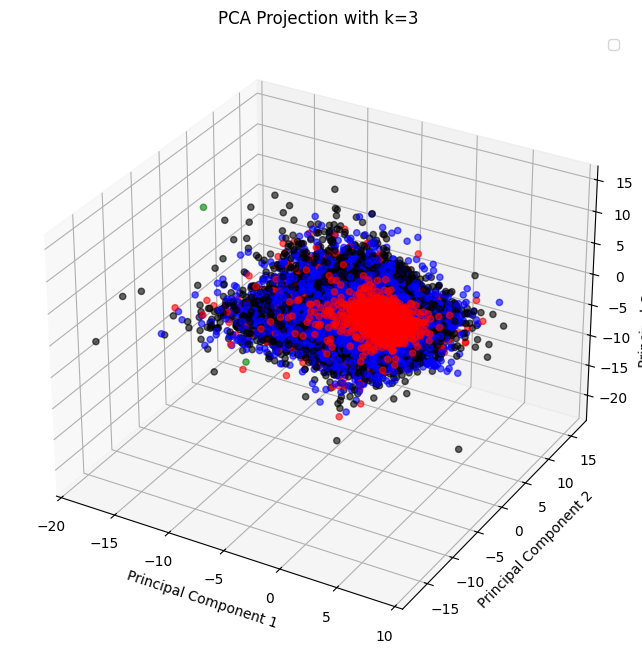

In [92]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_normalized.view(-1, 128)

# Center the data
mean = torch.mean(data, dim=0)
data_centered = data - mean

# Compute the covariance matrix
cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

# Sort eigenvectors by decreasing eigenvalues
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, sorted_indices]

# Select top 3 eigenvectors
k = 3
principal_components = eigenvectors[:, :k]

# Project the data onto the top 3 principal components
data_projected = torch.mm(data_centered, principal_components)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


# weights layer 0
for class_idx in range(27):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="red")

# weights layer 1
for class_idx in range(27, 27 + 128):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="blue")
    
# weights layer 2
for class_idx in range(27 + 128, 27 + 2*128):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="black")
    
# weights layer 3
for class_idx in range(27 + 2*128, 27 + 2*128 + 1):
    class_data = data_projected[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="green")



ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('PCA Projection with k=3')
plt.legend()
plt.show()



tensor([  0,   0,   0,  ..., 286, 286, 286])


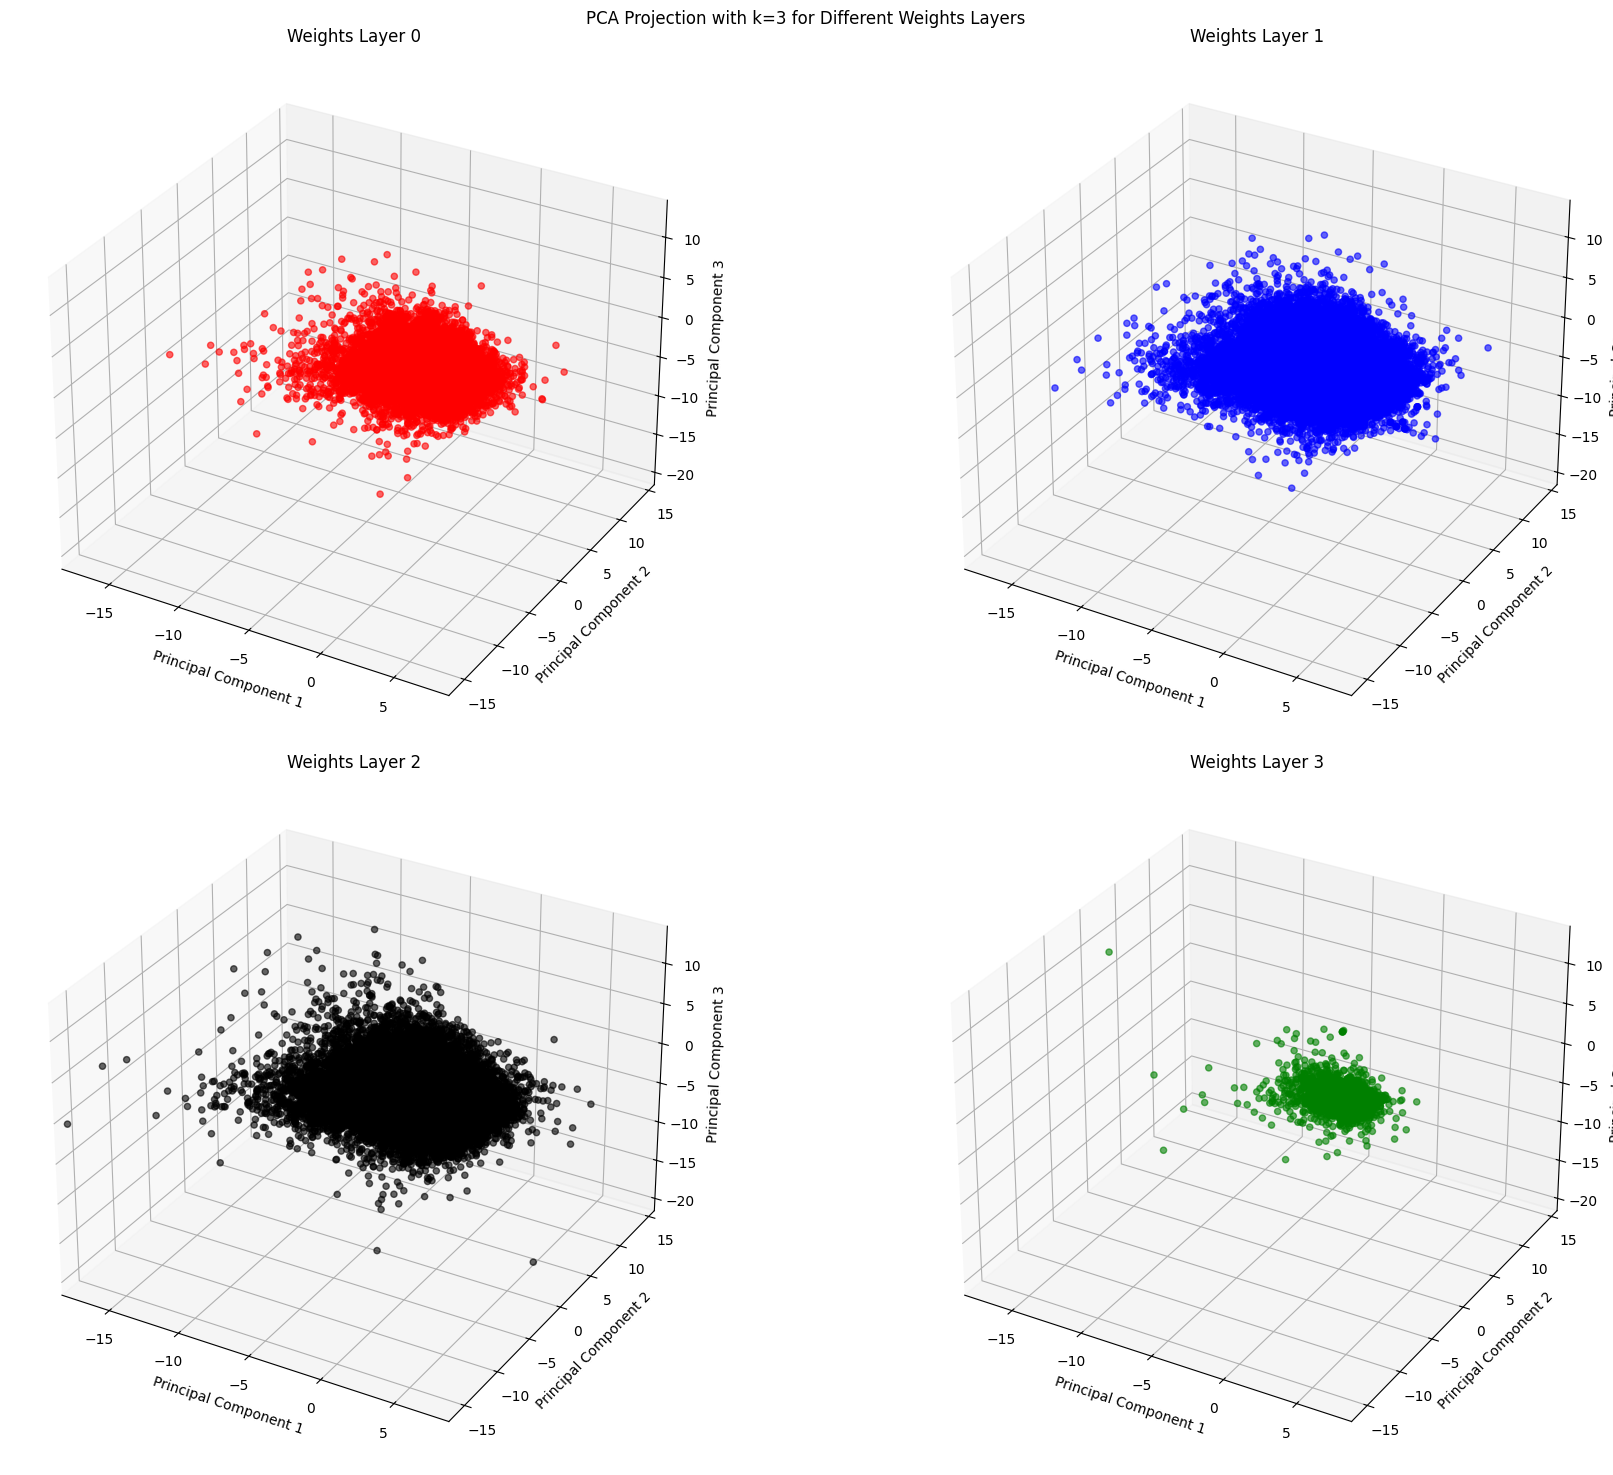

In [15]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_normalized.view(-1, 128)

# Center the data
mean = torch.mean(data, dim=0)
data_centered = data - mean

# Compute the covariance matrix
cov_matrix = torch.mm(data_centered.T, data_centered) / (data_centered.size(0) - 1)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix, UPLO='U')

# Sort eigenvectors by decreasing eigenvalues
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, sorted_indices]

# Select top 3 eigenvectors
k = 3
principal_components = eigenvectors[:, :k]

# Project the data onto the top 3 principal components
data_projected = torch.mm(data_centered, principal_components)

# Get axis limits for consistent comparison
min_vals = data_projected.min(dim=0).values
max_vals = data_projected.max(dim=0).values

# Visualization for each layer
fig = plt.figure(figsize=(20, 15))

# Weights layer 0
ax1 = fig.add_subplot(221, projection='3d')
for class_idx in range(27):
    class_data = data_projected[labels == class_idx]
    ax1.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="red")
ax1.set_xlim(min_vals[0].item(), max_vals[0].item())
ax1.set_ylim(min_vals[1].item(), max_vals[1].item())
ax1.set_zlim(min_vals[2].item(), max_vals[2].item())
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
ax1.set_title('Weights Layer 0')

# Weights layer 1
ax2 = fig.add_subplot(222, projection='3d')
for class_idx in range(27, 27 + 128):
    class_data = data_projected[labels == class_idx]
    ax2.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="blue")
ax2.set_xlim(min_vals[0].item(), max_vals[0].item())
ax2.set_ylim(min_vals[1].item(), max_vals[1].item())
ax2.set_zlim(min_vals[2].item(), max_vals[2].item())
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_zlabel('Principal Component 3')
ax2.set_title('Weights Layer 1')

# Weights layer 2
ax3 = fig.add_subplot(223, projection='3d')
for class_idx in range(27 + 128, 27 + 2 * 128):
    class_data = data_projected[labels == class_idx]
    ax3.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="black")
ax3.set_xlim(min_vals[0].item(), max_vals[0].item())
ax3.set_ylim(min_vals[1].item(), max_vals[1].item())
ax3.set_zlim(min_vals[2].item(), max_vals[2].item())
ax3.set_xlabel('Principal Component 1')
ax3.set_ylabel('Principal Component 2')
ax3.set_zlabel('Principal Component 3')
ax3.set_title('Weights Layer 2')

# Weights layer 3
ax4 = fig.add_subplot(224, projection='3d')
for class_idx in range(27 + 2 * 128, 27 + 2 * 128 + 1):
    class_data = data_projected[labels == class_idx]
    ax4.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], alpha=0.6, c="green")
ax4.set_xlim(min_vals[0].item(), max_vals[0].item())
ax4.set_ylim(min_vals[1].item(), max_vals[1].item())
ax4.set_zlim(min_vals[2].item(), max_vals[2].item())
ax4.set_xlabel('Principal Component 1')
ax4.set_ylabel('Principal Component 2')
ax4.set_zlabel('Principal Component 3')
ax4.set_title('Weights Layer 3')

plt.suptitle('PCA Projection with k=3 for Different Weights Layers')
plt.tight_layout()
plt.show()


In [146]:
weight_vector = shapeNetData[0][0]
weight_vector.shape

torch.Size([287, 128])

pos_enc.shape

In [192]:
batch.shape

torch.Size([1024, 129])

In [195]:
model.encoder

Sequential(
  (0): Linear(in_features=128, out_features=128, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): GELU(approximate='none')
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): GELU(approximate='none')
  (6): Linear(in_features=64, out_features=64, bias=True)
)

In [194]:
model.encoder(batch[:, :128])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x128 and 64x64)

In [205]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_normalized.view(-1, 128)

pos_enc = torch.Tensor([i for _ in range(3883) for i in range(287)]).unsqueeze(-1)
concatenated_data = torch.cat((data, pos_enc), dim=1)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.n_emb = 64
        
        self.emb = nn.Embedding(287, self.n_emb)
        
        self.encoder = nn.Sequential(
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64 + self.n_emb, 64 + self.n_emb),
            nn.GELU(),
            nn.Linear(64 + self.n_emb, 64 + self.n_emb),
            nn.GELU(),
            nn.Linear(64 + self.n_emb, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):
        pos = x[:, -1].int()
        x = x[:, :-1]
        latent = self.encoder(x)
        embedding = self.emb(pos)

        reconstructed = self.decoder(torch.cat((latent, embedding), dim=1))
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 100
batch_size = 128
data_loader = torch.utils.data.DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

exp_avg_loss = None

for epoch in range(num_epochs):
    bar = tqdm(data_loader)
    for batch in bar:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch[:, :128])
        loss.backward()
        optimizer.step()
        if exp_avg_loss == None:
            exp_avg_loss = loss
        exp_avg_loss = 0.99*exp_avg_loss + 0.01*loss
        bar.set_description("Loss %f" % exp_avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# # Plot each class with its respective color
for class_idx in range(27):
    class_data = latent_space[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])


ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


Loss 0.203572: 100%|██████████| 8707/8707 [00:28<00:00, 306.43it/s]


Epoch [1/100], Loss: 0.2649


Loss 0.160226: 100%|██████████| 8707/8707 [00:27<00:00, 312.23it/s]


Epoch [2/100], Loss: 0.1876


Loss 0.139197: 100%|██████████| 8707/8707 [00:28<00:00, 310.02it/s]


Epoch [3/100], Loss: 0.1320


Loss 0.123718: 100%|██████████| 8707/8707 [00:30<00:00, 284.71it/s]


Epoch [4/100], Loss: 0.1144


Loss 0.115785: 100%|██████████| 8707/8707 [00:28<00:00, 305.15it/s]


Epoch [5/100], Loss: 0.1291


Loss 0.107713: 100%|██████████| 8707/8707 [00:28<00:00, 306.98it/s]


Epoch [6/100], Loss: 0.1215


Loss 0.101307: 100%|██████████| 8707/8707 [00:28<00:00, 307.01it/s]


Epoch [7/100], Loss: 0.0814


Loss 0.097902: 100%|██████████| 8707/8707 [00:28<00:00, 301.93it/s]


Epoch [8/100], Loss: 0.0988


Loss 0.092792: 100%|██████████| 8707/8707 [00:29<00:00, 299.91it/s]


Epoch [9/100], Loss: 0.0856


Loss 0.091087: 100%|██████████| 8707/8707 [00:28<00:00, 308.65it/s]


Epoch [10/100], Loss: 0.0764


Loss 0.086008: 100%|██████████| 8707/8707 [00:27<00:00, 312.15it/s]


Epoch [11/100], Loss: 0.0827


Loss 0.082567: 100%|██████████| 8707/8707 [00:28<00:00, 310.24it/s]


Epoch [12/100], Loss: 0.0841


Loss 0.081081: 100%|██████████| 8707/8707 [00:28<00:00, 301.13it/s]


Epoch [13/100], Loss: 0.0774


Loss 0.077201: 100%|██████████| 8707/8707 [00:29<00:00, 298.91it/s]


Epoch [14/100], Loss: 0.0866


Loss 0.076257: 100%|██████████| 8707/8707 [00:28<00:00, 304.93it/s]


Epoch [15/100], Loss: 0.0607


Loss 0.073604: 100%|██████████| 8707/8707 [00:27<00:00, 312.57it/s]


Epoch [16/100], Loss: 0.0645


Loss 0.072363: 100%|██████████| 8707/8707 [00:27<00:00, 313.88it/s]


Epoch [17/100], Loss: 0.1181


Loss 0.074672: 100%|██████████| 8707/8707 [00:28<00:00, 305.53it/s]


Epoch [18/100], Loss: 0.0661


Loss 0.073051: 100%|██████████| 8707/8707 [00:28<00:00, 303.25it/s]


Epoch [19/100], Loss: 0.0753


Loss 0.072531:  11%|█         | 943/8707 [00:03<00:28, 277.26it/s]


KeyboardInterrupt: 

In [30]:
all_weights_layer_0_normalized = torch.stack([sample[0][:27] for sample in shapeNetData_normalized])

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_layer_0_normalized.view(-1, 128)

pos_enc = torch.Tensor([i for _ in range(3883) for i in range(287)]).unsqueeze(-1)
concatenated_data = torch.cat((data, pos_enc), dim=1)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.n_emb = 64
        
        self.emb = nn.Embedding(287, self.n_emb)
        
        self.encoder = nn.Sequential(
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64 + self.n_emb, 64 + self.n_emb),
            nn.GELU(),
            nn.Linear(64 + self.n_emb, 64 + self.n_emb),
            nn.GELU(),
            nn.Linear(64 + self.n_emb, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):
        pos = x[:, -1].int()
        x = x[:, :-1]
        latent = self.encoder(x)
        embedding = self.emb(pos)

        reconstructed = self.decoder(torch.cat((latent, embedding), dim=1))
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training the autoencoder
num_epochs = 100
batch_size = 128
data_loader = torch.utils.data.DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

exp_avg_loss = None

for epoch in range(num_epochs):
    bar = tqdm(data_loader)
    for batch in bar:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch[:, :128])
        loss.backward()
        optimizer.step()
        if exp_avg_loss == None:
            exp_avg_loss = loss
        exp_avg_loss = 0.99*exp_avg_loss + 0.01*loss
        bar.set_description("Loss %f" % exp_avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# # Plot each class with its respective color
for class_idx in range(27):
    class_data = latent_space[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])


ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 104841 but got size 1114421 for tensor number 1 in the list.

In [213]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_normalized.view(-1, 128)

pos_enc = torch.Tensor([i for _ in range(3883) for i in range(287)]).unsqueeze(-1)
concatenated_data = torch.cat((data, pos_enc), dim=1)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.n_emb = 128
        
        self.emb = nn.Embedding(287, self.n_emb)
        
        self.encoder = nn.Sequential(
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64 + self.n_emb, 64 + self.n_emb),
            nn.GELU(),
            nn.Linear(64 + self.n_emb, 64 + self.n_emb),
            nn.GELU(),
            nn.Linear(64 + self.n_emb, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):
        pos = x[:, -1].int()
        x = x[:, :-1]
        latent = self.encoder(x)
        embedding = self.emb(pos)

        reconstructed = self.decoder(torch.cat((latent, embedding), dim=1))
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
#model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 100
batch_size = 128
data_loader = torch.utils.data.DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

exp_avg_loss = None

for epoch in range(num_epochs):
    bar = tqdm(data_loader)
    for batch in bar:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch[:, :128])
        loss.backward()
        optimizer.step()
        if exp_avg_loss == None:
            exp_avg_loss = loss
        exp_avg_loss = 0.99*exp_avg_loss + 0.01*loss
        bar.set_description("Loss %f" % exp_avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# # Plot each class with its respective color
for class_idx in range(27):
    class_data = latent_space[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])


ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


Loss 0.038199: 100%|██████████| 2177/2177 [00:14<00:00, 150.89it/s]


Epoch [1/100], Loss: 0.0390


Loss 0.038178: 100%|██████████| 2177/2177 [00:15<00:00, 139.87it/s]


Epoch [2/100], Loss: 0.0302


Loss 0.038033:  25%|██▍       | 534/2177 [00:04<00:13, 123.82it/s]


KeyboardInterrupt: 

In [224]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_normalized.view(-1, 128)

pos_enc = torch.Tensor([i for _ in range(3883) for i in range(287)]).unsqueeze(-1)
concatenated_data = torch.cat((data, pos_enc), dim=1)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.n_emb = 64
        
        self.emb = nn.Embedding(287, self.n_emb)
        
        self.encoder = nn.Sequential(
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Linear(128, 112),
            nn.GELU(),
            nn.Linear(112, 96),
            nn.GELU(),
            nn.Linear(96, 80),
            nn.GELU(),
            nn.Linear(80, 64),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64 + self.n_emb, 64 + self.n_emb),
            nn.GELU(),
            nn.Linear(64 + self.n_emb, 64 + self.n_emb),
            nn.GELU(),
            nn.Linear(64 + self.n_emb, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):
        pos = x[:, -1].int()
        x = x[:, :-1]
        latent = self.encoder(x)
        embedding = self.emb(pos)

        reconstructed = self.decoder(torch.cat((latent, embedding), dim=1))
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 100
batch_size = 128
data_loader = torch.utils.data.DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

exp_avg_loss = None

for epoch in range(num_epochs):
    bar = tqdm(data_loader)
    for batch in bar:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch[:, :128])
        loss.backward()
        optimizer.step()
        if exp_avg_loss == None:
            exp_avg_loss = loss
        exp_avg_loss = 0.99*exp_avg_loss + 0.01*loss
        bar.set_description("Loss %f" % exp_avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# # Plot each class with its respective color
for class_idx in range(27):
    class_data = latent_space[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])


ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


KeyboardInterrupt: 

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_normalized.view(-1, 128)

pos_enc = torch.Tensor([i for _ in range(3883) for i in range(287)]).unsqueeze(-1)
concatenated_data = torch.cat((data, pos_enc), dim=1)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.n_emb = 64
        
        self.emb = nn.Embedding(287, self.n_emb)
        
        self.encoder = nn.Sequential(
            nn.Linear(128, 112),
            nn.GELU(),
            nn.Linear(112, 96),
            nn.GELU(),
            nn.Linear(96, 80),
            nn.GELU(),
            nn.Linear(80, 72),
            nn.GELU(),
            nn.Linear(72, 64),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64 + self.n_emb, 64 + self.n_emb),
            nn.GELU(),
            nn.Linear(64 + self.n_emb, 64 + self.n_emb),
            nn.GELU(),
            nn.Linear(64 + self.n_emb, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):
        pos = x[:, -1].int()
        x = x[:, :-1]
        latent = self.encoder(x)
        embedding = self.emb(pos)

        reconstructed = self.decoder(torch.cat((latent, embedding), dim=1))
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
#model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training the autoencoder
num_epochs = 100
batch_size = 128
data_loader = torch.utils.data.DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

exp_avg_loss = None

for epoch in range(num_epochs):
    bar = tqdm(data_loader)
    for batch in bar:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch[:, :128])
        loss.backward()
        optimizer.step()
        if exp_avg_loss == None:
            exp_avg_loss = loss
        exp_avg_loss = 0.99*exp_avg_loss + 0.01*loss
        bar.set_description("Loss %f" % exp_avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# # Plot each class with its respective color
for class_idx in range(27):
    class_data = latent_space[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])


ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


Loss 0.052962: 100%|██████████| 8707/8707 [00:43<00:00, 197.91it/s]


Epoch [1/100], Loss: 0.0458


Loss 0.052434: 100%|██████████| 8707/8707 [00:41<00:00, 208.92it/s]


Epoch [2/100], Loss: 0.0358


Loss 0.051363: 100%|██████████| 8707/8707 [00:43<00:00, 198.15it/s]


Epoch [3/100], Loss: 0.0362


Loss 0.050847: 100%|██████████| 8707/8707 [00:43<00:00, 198.03it/s]


Epoch [4/100], Loss: 0.0508


Loss 0.049548: 100%|██████████| 8707/8707 [00:45<00:00, 192.71it/s]


Epoch [5/100], Loss: 0.0691


Loss 0.048637: 100%|██████████| 8707/8707 [00:44<00:00, 194.33it/s]


Epoch [6/100], Loss: 0.0592


Loss 0.049690: 100%|██████████| 8707/8707 [00:42<00:00, 206.85it/s]


Epoch [7/100], Loss: 0.0465


Loss 0.048703: 100%|██████████| 8707/8707 [00:41<00:00, 207.84it/s]


Epoch [8/100], Loss: 0.0375


Loss 0.049101: 100%|██████████| 8707/8707 [00:42<00:00, 204.77it/s]


Epoch [9/100], Loss: 0.0385


Loss 0.047359: 100%|██████████| 8707/8707 [00:41<00:00, 210.90it/s]


Epoch [10/100], Loss: 0.0398


Loss 0.045705: 100%|██████████| 8707/8707 [00:43<00:00, 201.33it/s]


Epoch [11/100], Loss: 0.0526


Loss 0.045530: 100%|██████████| 8707/8707 [00:47<00:00, 184.14it/s]


Epoch [12/100], Loss: 0.0433


Loss 0.046065: 100%|██████████| 8707/8707 [00:45<00:00, 191.07it/s]


Epoch [13/100], Loss: 0.0328


Loss 0.045120: 100%|██████████| 8707/8707 [00:44<00:00, 193.82it/s]


Epoch [14/100], Loss: 0.0370


Loss 0.044810: 100%|██████████| 8707/8707 [00:47<00:00, 185.25it/s]


Epoch [15/100], Loss: 0.0382


Loss 0.045553:  74%|███████▎  | 6411/8707 [00:33<00:12, 190.30it/s]


KeyboardInterrupt: 

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_normalized.view(-1, 128)

pos_enc = torch.Tensor([i for _ in range(3883) for i in range(287)]).unsqueeze(-1)
concatenated_data = torch.cat((data, pos_enc), dim=1)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.n_emb_input = 32
        self.n_emb_latent = 64
        
        self.emb_input = nn.Embedding(287, self.n_emb_input)
        self.emb_latent = nn.Embedding(287, self.n_emb_latent)
        
        self.encoder = nn.Sequential(
            nn.Linear(128 + self.n_emb_input, 112 + int(self.n_emb_input/2)),
            nn.GELU(),
            nn.Linear(112 + int(self.n_emb_input/2), 96 + int(self.n_emb_input/4)),
            nn.GELU(),
            nn.Linear(96 + int(self.n_emb_input/4), 80),
            nn.GELU(),
            nn.Linear(80, 72),
            nn.GELU(),
            nn.Linear(72, 64),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64 + self.n_emb_latent, 64 + self.n_emb_latent),
            nn.GELU(),
            nn.Linear(64 + self.n_emb_latent, 64 + self.n_emb_latent),
            nn.GELU(),
            nn.Linear(64 + self.n_emb_latent, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):
        pos = x[:, -1].int()
        embedding_input = self.emb_input(pos)
        x = torch.cat((x[:, :-1], embedding_input), dim=1)
        latent = self.encoder(x)
        embedding_latent = self.emb_latent(pos)

        reconstructed = self.decoder(torch.cat((latent, embedding_latent), dim=1))
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
#model = Autoencoder()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 100
batch_size = 128
data_loader = torch.utils.data.DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

exp_avg_loss = None

for epoch in range(num_epochs):
    bar = tqdm(data_loader)
    for batch in bar:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch[:, :128])
        loss.backward()
        optimizer.step()
        if exp_avg_loss == None:
            exp_avg_loss = loss
        exp_avg_loss = 0.95*exp_avg_loss + 0.05*loss
        bar.set_description("Loss %f" % exp_avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# # Plot each class with its respective color
for class_idx in range(27):
    class_data = latent_space[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])


ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


Loss 0.084431:  49%|████▉     | 4245/8707 [00:23<00:24, 184.09it/s]


KeyboardInterrupt: 

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

# Reshape the data
data = all_weights_layer_0_normalized.view(-1, 128)

pos_enc = torch.Tensor([i for _ in range(3883) for i in range(27)]).unsqueeze(-1)
concatenated_data = torch.cat((data, pos_enc), dim=1)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.n_emb_input = 64
        self.n_emb_latent = 64
        
        self.emb_input = nn.Embedding(287, self.n_emb_input)
        self.emb_latent = nn.Embedding(287, self.n_emb_latent)
        
        self.encoder = nn.Sequential(
            nn.Linear(128 + self.n_emb_input, 112 + int(self.n_emb_input/2)),
            nn.GELU(),
            nn.Linear(112 + int(self.n_emb_input/2), 96 + int(self.n_emb_input/4)),
            nn.Tanh(),
            nn.Linear(96 + int(self.n_emb_input/4), 96 + int(self.n_emb_input/8)),
            nn.Tanh(),
            nn.Linear(96 + int(self.n_emb_input/8), 96),
        )
        self.decoder = nn.Sequential(
            nn.Linear(96 + self.n_emb_latent, 64 + self.n_emb_latent),
            nn.Tanh(),
            nn.Linear(64 + self.n_emb_latent, 64 + self.n_emb_latent),
            nn.Tanh(),
            nn.Linear(64 + self.n_emb_latent, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):
        pos = x[:, -1].int()
        embedding_input = self.emb_input(pos)
        x = torch.cat((x[:, :-1], embedding_input), dim=1)
        latent = self.encoder(x)
        embedding_latent = self.emb_latent(pos)

        reconstructed = self.decoder(torch.cat((latent, embedding_latent), dim=1))
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 100
batch_size = 128
data_loader = torch.utils.data.DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

exp_avg_loss = None

for epoch in range(num_epochs):
    bar = tqdm(data_loader)
    for batch in bar:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch[:, :128])
        loss.backward()
        optimizer.step()
        if exp_avg_loss == None:
            exp_avg_loss = loss
        exp_avg_loss = 0.95*exp_avg_loss + 0.05*loss
        bar.set_description("Avg. Loss %f, Loss %f" % (exp_avg_loss, loss))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# # Plot each class with its respective color
for class_idx in range(27):
    class_data = latent_space[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])


ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


Avg. Loss 0.450704, Loss 0.256034: 100%|██████████| 820/820 [00:02<00:00, 319.89it/s]


Epoch [1/100], Loss: 0.2560


Avg. Loss 0.385166, Loss 0.344679: 100%|██████████| 820/820 [00:02<00:00, 369.44it/s]


Epoch [2/100], Loss: 0.3447


Avg. Loss 0.362613, Loss 0.694760: 100%|██████████| 820/820 [00:02<00:00, 348.87it/s]


Epoch [3/100], Loss: 0.6948


Avg. Loss 0.314802, Loss 0.153672: 100%|██████████| 820/820 [00:02<00:00, 335.51it/s]


Epoch [4/100], Loss: 0.1537


Avg. Loss 0.294123, Loss 0.253389: 100%|██████████| 820/820 [00:02<00:00, 325.80it/s]


Epoch [5/100], Loss: 0.2534


Avg. Loss 0.291668, Loss 0.443220: 100%|██████████| 820/820 [00:02<00:00, 325.85it/s]


Epoch [6/100], Loss: 0.4432


Avg. Loss 0.255950, Loss 0.128239: 100%|██████████| 820/820 [00:02<00:00, 340.39it/s]


Epoch [7/100], Loss: 0.1282


Avg. Loss 0.235952, Loss 0.275780: 100%|██████████| 820/820 [00:02<00:00, 357.76it/s]


Epoch [8/100], Loss: 0.2758


Avg. Loss 0.223944, Loss 0.164708: 100%|██████████| 820/820 [00:02<00:00, 335.47it/s]


Epoch [9/100], Loss: 0.1647


Avg. Loss 0.228676, Loss 0.490107: 100%|██████████| 820/820 [00:02<00:00, 348.04it/s]


Epoch [10/100], Loss: 0.4901


Avg. Loss 0.216551, Loss 0.401436: 100%|██████████| 820/820 [00:02<00:00, 335.29it/s]


Epoch [11/100], Loss: 0.4014


Avg. Loss 0.194318, Loss 0.124832: 100%|██████████| 820/820 [00:02<00:00, 343.17it/s]


Epoch [12/100], Loss: 0.1248


Avg. Loss 0.188694, Loss 0.194298: 100%|██████████| 820/820 [00:02<00:00, 345.57it/s]


Epoch [13/100], Loss: 0.1943


Avg. Loss 0.184793, Loss 0.228544: 100%|██████████| 820/820 [00:02<00:00, 362.36it/s]


Epoch [14/100], Loss: 0.2285


Avg. Loss 0.171261, Loss 0.130442: 100%|██████████| 820/820 [00:02<00:00, 344.09it/s]


Epoch [15/100], Loss: 0.1304


Avg. Loss 0.160630, Loss 0.068032: 100%|██████████| 820/820 [00:02<00:00, 342.07it/s]


Epoch [16/100], Loss: 0.0680


Avg. Loss 0.158818, Loss 0.106526: 100%|██████████| 820/820 [00:02<00:00, 334.39it/s]


Epoch [17/100], Loss: 0.1065


Avg. Loss 0.162103, Loss 0.211805: 100%|██████████| 820/820 [00:02<00:00, 338.11it/s]


Epoch [18/100], Loss: 0.2118


Avg. Loss 0.161460, Loss 0.336230: 100%|██████████| 820/820 [00:02<00:00, 323.09it/s]


Epoch [19/100], Loss: 0.3362


Avg. Loss 0.156340, Loss 0.315516: 100%|██████████| 820/820 [00:02<00:00, 358.94it/s]


Epoch [20/100], Loss: 0.3155


Avg. Loss 0.145479, Loss 0.145941: 100%|██████████| 820/820 [00:02<00:00, 328.84it/s]


Epoch [21/100], Loss: 0.1459


Avg. Loss 0.139282, Loss 0.127267: 100%|██████████| 820/820 [00:02<00:00, 327.56it/s]


Epoch [22/100], Loss: 0.1273


Avg. Loss 0.129139, Loss 0.096509: 100%|██████████| 820/820 [00:02<00:00, 343.60it/s]


Epoch [23/100], Loss: 0.0965


Avg. Loss 0.139520, Loss 0.130825: 100%|██████████| 820/820 [00:02<00:00, 362.57it/s]


Epoch [24/100], Loss: 0.1308


Avg. Loss 0.131119, Loss 0.151900: 100%|██████████| 820/820 [00:02<00:00, 350.20it/s]


Epoch [25/100], Loss: 0.1519


Avg. Loss 0.132891, Loss 0.177580: 100%|██████████| 820/820 [00:02<00:00, 356.42it/s]


Epoch [26/100], Loss: 0.1776


Avg. Loss 0.118557, Loss 0.098141: 100%|██████████| 820/820 [00:02<00:00, 345.87it/s]


Epoch [27/100], Loss: 0.0981


Avg. Loss 0.131631, Loss 0.235107: 100%|██████████| 820/820 [00:02<00:00, 340.40it/s]


Epoch [28/100], Loss: 0.2351


Avg. Loss 0.118328, Loss 0.084239: 100%|██████████| 820/820 [00:02<00:00, 371.72it/s]


Epoch [29/100], Loss: 0.0842


Avg. Loss 0.119380, Loss 0.091658: 100%|██████████| 820/820 [00:02<00:00, 348.11it/s]


Epoch [30/100], Loss: 0.0917


Avg. Loss 0.120337, Loss 0.091396: 100%|██████████| 820/820 [00:02<00:00, 354.44it/s]


Epoch [31/100], Loss: 0.0914


Avg. Loss 0.120852, Loss 0.129278: 100%|██████████| 820/820 [00:02<00:00, 342.39it/s]


Epoch [32/100], Loss: 0.1293


Avg. Loss 0.117473, Loss 0.095353: 100%|██████████| 820/820 [00:02<00:00, 372.59it/s]


Epoch [33/100], Loss: 0.0954


Avg. Loss 0.117967, Loss 0.106818: 100%|██████████| 820/820 [00:02<00:00, 344.49it/s]


Epoch [34/100], Loss: 0.1068


Avg. Loss 0.119041, Loss 0.197428: 100%|██████████| 820/820 [00:02<00:00, 343.83it/s]


Epoch [35/100], Loss: 0.1974


Avg. Loss 0.112478, Loss 0.098605: 100%|██████████| 820/820 [00:02<00:00, 346.98it/s]


Epoch [36/100], Loss: 0.0986


Avg. Loss 0.107069, Loss 0.093960: 100%|██████████| 820/820 [00:02<00:00, 342.06it/s]


Epoch [37/100], Loss: 0.0940


Avg. Loss 0.116827, Loss 0.201436: 100%|██████████| 820/820 [00:02<00:00, 365.92it/s]


Epoch [38/100], Loss: 0.2014


Avg. Loss 0.111042, Loss 0.061573: 100%|██████████| 820/820 [00:02<00:00, 339.51it/s]


Epoch [39/100], Loss: 0.0616


Avg. Loss 0.112017, Loss 0.238233: 100%|██████████| 820/820 [00:02<00:00, 343.40it/s]


Epoch [40/100], Loss: 0.2382


Avg. Loss 0.108403, Loss 0.088607: 100%|██████████| 820/820 [00:02<00:00, 344.26it/s]


Epoch [41/100], Loss: 0.0886


Avg. Loss 0.108036, Loss 0.147264: 100%|██████████| 820/820 [00:02<00:00, 338.09it/s]


Epoch [42/100], Loss: 0.1473


Avg. Loss 0.096342, Loss 0.039700: 100%|██████████| 820/820 [00:02<00:00, 344.75it/s]


Epoch [43/100], Loss: 0.0397


Avg. Loss 0.099865, Loss 0.071121: 100%|██████████| 820/820 [00:02<00:00, 374.78it/s]


Epoch [44/100], Loss: 0.0711


Avg. Loss 0.096789, Loss 0.058369: 100%|██████████| 820/820 [00:02<00:00, 347.14it/s]


Epoch [45/100], Loss: 0.0584


Avg. Loss 0.099877, Loss 0.115654: 100%|██████████| 820/820 [00:02<00:00, 338.89it/s]


Epoch [46/100], Loss: 0.1157


Avg. Loss 0.102504, Loss 0.117309: 100%|██████████| 820/820 [00:02<00:00, 350.37it/s]


Epoch [47/100], Loss: 0.1173


Avg. Loss 0.096368, Loss 0.059507: 100%|██████████| 820/820 [00:02<00:00, 333.31it/s]


Epoch [48/100], Loss: 0.0595


Avg. Loss 0.094667, Loss 0.061843: 100%|██████████| 820/820 [00:02<00:00, 343.20it/s]


Epoch [49/100], Loss: 0.0618


Avg. Loss 0.096827, Loss 0.133300: 100%|██████████| 820/820 [00:02<00:00, 366.19it/s]


Epoch [50/100], Loss: 0.1333


Avg. Loss 0.092184, Loss 0.056746: 100%|██████████| 820/820 [00:02<00:00, 337.47it/s]


Epoch [51/100], Loss: 0.0567


Avg. Loss 0.098367, Loss 0.149056: 100%|██████████| 820/820 [00:02<00:00, 334.07it/s]


Epoch [52/100], Loss: 0.1491


Avg. Loss 0.085315, Loss 0.053372: 100%|██████████| 820/820 [00:02<00:00, 340.09it/s]


Epoch [53/100], Loss: 0.0534


Avg. Loss 0.092087, Loss 0.123673: 100%|██████████| 820/820 [00:02<00:00, 339.23it/s]


Epoch [54/100], Loss: 0.1237


Avg. Loss 0.087768, Loss 0.146881: 100%|██████████| 820/820 [00:02<00:00, 315.61it/s]


Epoch [55/100], Loss: 0.1469


Avg. Loss 0.085678, Loss 0.039713: 100%|██████████| 820/820 [00:02<00:00, 299.64it/s]


Epoch [56/100], Loss: 0.0397


Avg. Loss 0.084548, Loss 0.044960: 100%|██████████| 820/820 [00:03<00:00, 258.74it/s]


Epoch [57/100], Loss: 0.0450


Avg. Loss 0.084117, Loss 0.059723: 100%|██████████| 820/820 [00:03<00:00, 213.10it/s]


Epoch [58/100], Loss: 0.0597


Avg. Loss 0.083755, Loss 0.088421:   7%|▋         | 54/820 [00:00<00:03, 195.95it/s]


KeyboardInterrupt: 

In [35]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Generate class labels
labels = torch.arange(27).repeat_interleave(4045)

# Reshape the data
data = all_weights.view(-1, 128)

# Convert data to numpy array for t-SNE
data_np = data.numpy()

# Perform 3D t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
data_tsne = tsne.fit_transform(data_np)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# Plot each class with its respective color
for class_idx in range(27):
    class_data = data_tsne[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.title('3D t-SNE Projection')
plt.legend()
plt.show()


/Users/luis/uni/adl4cv/adl4cv/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KeyboardInterrupt: 

In [24]:
all_weights_layer_0_neuron_0_normalized = torch.stack([sample[0][0] for sample in shapeNetData_normalized])


In [25]:
all_weights_layer_0_neuron_0_normalized[0]

tensor([-2.0924e+00, -2.2313e-01,  2.3014e-01, -3.5076e-01,  9.8972e-11,
         2.5515e-01, -3.8691e-01, -1.9699e-01,  1.2917e-01,  1.4201e+00,
         1.7395e+00, -1.9508e-01,  1.6847e-01, -3.3630e-02,  1.5209e-01,
        -2.1369e-01,  4.3431e-02,  2.8157e-01,  9.8972e-11, -3.3005e-01,
         4.1002e-01,  4.4515e-01, -1.1803e-01,  3.9888e-01, -7.8927e-01,
         6.5327e-01,  1.0536e+00, -1.3365e-08,  1.2560e-01, -1.5579e-01,
         8.1312e-02, -2.4195e-02, -4.1959e-01, -1.9416e-01,  5.2042e-02,
         2.2070e+00, -6.5510e-02, -2.6829e-08, -5.1035e-01, -3.2030e-01,
        -2.2583e-01,  4.2570e-01,  1.3983e-01,  6.1588e-01,  4.3328e-01,
        -3.3323e-02, -2.3188e-01, -1.8856e-01, -4.0497e-01,  4.0556e-02,
         1.0029e-01,  2.2558e-01,  1.4045e-01,  5.2528e-02, -6.6724e-02,
         2.5393e-03,  1.0262e+00, -2.3909e-01,  1.0968e-01,  1.2054e-01,
         4.3319e-01, -5.4358e-01,  1.1341e+00,  1.0339e+00, -8.4959e-02,
         8.5405e-03,  3.4803e-01, -1.8474e+00,  9.8

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import wandb
import math

warmup_iters = 5
lr_decay_iters = 1000
learning_rate = 0.001

def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return 0.0
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (
        lr_decay_iters - warmup_iters
    )
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return coeff * (learning_rate)

wandb.init(project="autoencoder")

# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

all_weights_layer_0_neuron_0_normalized = torch.stack([sample[0][0] for sample in shapeNetData_normalized])

# Reshape the data
data = all_weights_layer_0_neuron_0_normalized.view(-1, 128)

pos_enc = torch.Tensor([i for _ in range(3883) for i in range(1)]).unsqueeze(-1)
concatenated_data = torch.cat((data, pos_enc), dim=1)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.n_emb_input = 32
        self.n_emb_latent = 64
        
        
        self.encoder = nn.Sequential(
            nn.Linear(128, 112),
            nn.GELU(),
            nn.Linear(112, 96),
            nn.GELU(),
            nn.Linear(96, 80),
            nn.GELU(),
            nn.Linear(80, 64),
        )
        self.decoder = nn.Sequential(
            nn.GELU(),
            nn.Linear(64, 80),
            nn.GELU(),
            nn.Linear(80, 96),
            nn.GELU(),
            nn.Linear(96, 112),
            nn.GELU(),
            nn.Linear(112, 128)
        )

    def forward(self, x):
        latent = self.encoder(x[:, :-1])

        reconstructed = self.decoder(latent)
        return latent, reconstructed

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the autoencoder
num_epochs = lr_decay_iters
batch_size = 128
data_loader = torch.utils.data.DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

exp_avg_loss = None

bar = tqdm(range(num_epochs))

for epoch in bar:
    for batch in data_loader:
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch[:, :128])
        loss.backward()
        optimizer.step()
        if exp_avg_loss == None:
            exp_avg_loss = loss
        #wandb.log({"sample loss": loss.item()})
        exp_avg_loss = 0.95*exp_avg_loss + 0.05*loss
    bar.set_description("Avg. Loss %f" % exp_avg_loss)
    # determine and set the learning rate for this iteration
    lr = get_lr(epoch)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    wandb.log({"lr": lr, "epoch": epoch, "loss": exp_avg_loss.item()})



epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,49999
loss,0.03202
lr,0.0


Avg. Loss 0.087017: 100%|██████████| 1000/1000 [01:08<00:00, 14.70it/s]


torch.Size([128])

In [33]:
model(concatenated_data[0].unsqueeze(0))[1]

tensor([[-2.0825e+00, -1.4239e-01,  2.1038e-01, -1.0551e-01,  1.3492e-07,
          5.9920e-01, -5.6248e-01, -1.0703e-01,  4.0631e-03,  1.1563e+00,
          1.0961e+00, -1.2586e-01,  3.8687e-01,  2.6639e-01,  3.1983e-01,
         -4.7307e-01,  1.1574e-01,  1.5602e-01,  1.3614e-07, -1.3383e-01,
          3.3165e-01,  5.3287e-01, -6.6585e-02,  3.5317e-02, -9.0286e-01,
          6.4557e-01,  7.9866e-01,  2.4232e-07, -3.8580e-03, -9.2728e-02,
          2.4415e-01, -7.6161e-02, -6.0877e-01, -2.5460e-02, -6.7405e-01,
          1.7699e+00,  1.2866e-01,  5.0304e-07, -3.5654e-01, -5.1977e-01,
         -2.7958e-01,  4.0125e-01,  1.4558e-01,  5.4550e-01, -9.8201e-03,
         -5.9888e-02, -8.1557e-02, -6.8603e-01, -2.6687e-01,  4.1349e-01,
          2.2562e-02, -1.3203e-01,  1.3378e-01,  1.1049e-01,  3.1427e-01,
          8.6656e-02,  1.1625e+00, -3.4201e-01,  1.0287e-01,  1.0312e-01,
          5.8526e-01,  7.5491e-02,  9.3590e-01,  8.8942e-01,  3.0259e-01,
         -3.7765e-02,  8.6842e-01, -1.

In [45]:
(model(concatenated_data[0].unsqueeze(0))[1] - all_weights_layer_0_neuron_0_normalized[0]).abs().flatten()

tensor([9.8975e-03, 8.0744e-02, 1.9761e-02, 2.4525e-01, 1.3482e-07, 3.4406e-01,
        1.7557e-01, 8.9959e-02, 1.2511e-01, 2.6378e-01, 6.4333e-01, 6.9222e-02,
        2.1840e-01, 3.0002e-01, 1.6774e-01, 2.5938e-01, 7.2309e-02, 1.2555e-01,
        1.3604e-07, 1.9622e-01, 7.8373e-02, 8.7714e-02, 5.1443e-02, 3.6357e-01,
        1.1359e-01, 7.7040e-03, 2.5493e-01, 2.5569e-07, 1.2946e-01, 6.3060e-02,
        1.6284e-01, 5.1967e-02, 1.8918e-01, 1.6870e-01, 7.2609e-01, 4.3713e-01,
        1.9417e-01, 5.2987e-07, 1.5382e-01, 1.9946e-01, 5.3755e-02, 2.4449e-02,
        5.7499e-03, 7.0388e-02, 4.4310e-01, 2.6565e-02, 1.5032e-01, 4.9747e-01,
        1.3810e-01, 3.7293e-01, 7.7731e-02, 3.5760e-01, 6.6716e-03, 5.7965e-02,
        3.8100e-01, 8.4117e-02, 1.3634e-01, 1.0292e-01, 6.8063e-03, 1.7421e-02,
        1.5207e-01, 6.1908e-01, 1.9825e-01, 1.4444e-01, 3.8755e-01, 4.6305e-02,
        5.2039e-01, 2.3966e-01, 1.1766e-07, 1.0470e-01, 2.1904e-01, 2.8353e-01,
        1.1846e-01, 1.6572e-04, 1.1439e-

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import wandb
import math


warmup_iters = 100
lr_decay_iters = 250000
learning_rate = 0.001

def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return 0.0
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (
        lr_decay_iters - warmup_iters
    )
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return coeff * (learning_rate)

wandb.init(project="autoencoder")


# Generate class labels
labels = torch.arange(287).repeat_interleave(4045)

data = all_weights_normalized.view(-1, 128)

pos_enc = torch.Tensor([i for _ in range(3883) for i in range(287)]).unsqueeze(-1)
concatenated_data = torch.cat((data, pos_enc), dim=1)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.n_emb_input = 64
        self.n_emb_latent = 64
        
        self.emb_input = nn.Embedding(287, self.n_emb_input)
        self.emb_latent = nn.Embedding(287, self.n_emb_latent)
        
        self.encoder = nn.Sequential(
            nn.Linear(128 + self.n_emb_input, 112 + int(self.n_emb_input/2)),
            nn.GELU(),
            nn.Linear(112 + int(self.n_emb_input/2), 96 + int(self.n_emb_input/4)),
            nn.Tanh(),
            nn.Linear(96 + int(self.n_emb_input/4), 96 + int(self.n_emb_input/8)),
            nn.Tanh(),
            nn.Linear(96 + int(self.n_emb_input/8), 96),
        )
        self.decoder = nn.Sequential(
            nn.Linear(96 + self.n_emb_latent, 64 + self.n_emb_latent),
            nn.Tanh(),
            nn.Linear(64 + self.n_emb_latent, 64 + self.n_emb_latent),
            nn.Tanh(),
            nn.Linear(64 + self.n_emb_latent, 128),
            nn.GELU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):
        pos = x[:, -1].int()
        embedding_input = self.emb_input(pos)
        x = torch.cat((x[:, :-1], embedding_input), dim=1)
        latent = self.encoder(x)
        embedding_latent = self.emb_latent(pos)

        reconstructed = self.decoder(torch.cat((latent, embedding_latent), dim=1))
        return latent, reconstructed

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the autoencoder
num_epochs = lr_decay_iters
batch_size = 128
data_loader = torch.utils.data.DataLoader(concatenated_data, batch_size=batch_size, shuffle=True)

exp_avg_loss = None

iters = 0

while True:
    bar = tqdm(data_loader)
    for batch in bar:
        lr = get_lr(iters)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        optimizer.zero_grad()
        latent, reconstructed = model(batch)
        loss = criterion(reconstructed, batch[:, :128])
        loss.backward()
        optimizer.step()
        if exp_avg_loss == None:
            exp_avg_loss = loss
        exp_avg_loss = 0.95*exp_avg_loss + 0.05*loss
        bar.set_description("Avg. Loss %f, Loss %f" % (exp_avg_loss, loss))
        iters += 1
    
        wandb.log({"lr": lr, "iters": iters, "loss": exp_avg_loss.item()})
    if iters == lr_decay_iters:
            break

# Project the data into the latent space
with torch.no_grad():
    latent_space, _ = model(data)

# Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate a color map for the 27 classes
cmap = plt.get_cmap("tab20", 27)
colors = cmap(labels)

# # Plot each class with its respective color
for class_idx in range(27):
    class_data = latent_space[labels == class_idx]
    ax.scatter(class_data[:, 0], class_data[:, 1], class_data[:, 2], label=f'Class {class_idx}', alpha=0.6, c=colors[labels == class_idx])


ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('Latent Space Projection with Autoencoder')
plt.legend()
plt.show()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Avg. Loss 0.020671, Loss 0.021045:  67%|██████▋   | 5854/8707 [00:20<00:09, 289.96it/s]


KeyboardInterrupt: 

In [9]:
(model(concatenated_data[0].unsqueeze(0))[1] - all_weights_normalized[0]).abs().flatten()

tensor([0.0763, 0.0094, 0.2386,  ..., 0.0909, 0.3563, 0.8397],
       grad_fn=<ViewBackward0>)

In [11]:
model(concatenated_data[0].unsqueeze(0))[1]

tensor([[-1.2341e+00, -1.3285e-01,  3.6592e-01, -1.8565e-01, -1.1950e-03,
          1.4009e-01, -1.8583e-01, -4.1200e-03, -9.8423e-03,  7.2889e-01,
          6.8691e-01,  4.9664e-02,  8.7761e-02, -1.6124e-02,  7.6549e-02,
         -1.3250e-01,  2.8691e-02,  2.7883e-02, -5.1435e-02,  8.5023e-02,
          1.6944e-01,  2.3730e-01, -1.7661e-01,  8.8046e-02,  5.6361e-02,
          4.5873e-01,  5.9176e-01,  2.9114e-02,  1.4449e-01, -6.8064e-02,
          1.2779e-01,  9.1255e-02, -1.1242e-01, -4.7473e-03,  4.5557e-02,
          7.1053e-01, -3.0742e-01,  7.0854e-02, -3.1233e-01, -1.8342e-01,
         -1.1435e-01,  1.1954e-01,  1.0353e-01,  3.2446e-01,  2.4689e-01,
         -9.1555e-03,  9.8427e-02,  4.0173e-01, -2.3913e-01,  3.1854e-02,
          2.2982e-02,  1.4510e-01,  8.6964e-02, -4.0564e-02, -8.5524e-02,
          4.3809e-03,  5.4572e-01, -1.2571e-01,  3.8681e-02,  2.1077e-01,
          2.1260e-01, -2.8790e-01,  6.0336e-01,  6.5188e-01, -2.5134e-01,
          4.1630e-02,  7.7127e-02, -9.

In [10]:
all_weights_normalized[0]

tensor([[-1.1579e+00, -1.2348e-01,  1.2735e-01,  ...,  1.6906e-03,
         -1.5502e-01,  2.3085e-01],
        [-2.2911e+00,  1.0880e+00, -1.1856e-01,  ...,  3.3304e-04,
          7.9498e-02, -2.0564e-01],
        [-1.9472e-01,  3.2966e-01,  4.2780e-02,  ..., -9.9324e-04,
          6.2575e-02, -8.3910e-01],
        ...,
        [ 6.4447e-03,  1.2666e-01,  2.1990e-02,  ...,  4.8739e-03,
         -9.9340e-02,  1.3855e-01],
        [-1.3227e-01, -2.7540e-01,  4.0696e-03,  ..., -1.1824e-01,
         -4.0170e-01,  3.0282e-02],
        [-6.1585e-01,  4.6711e-02, -4.3748e-01,  ...,  6.3654e-02,
          1.1271e-01, -6.3559e-01]])

In [12]:
all_weights_normalized.view()

torch.Size([3883, 287, 128])

In [14]:
8*8

64